# Customer Satisfaction Airline Survey, Analysis and Prediction

This notebook is to showcase: 
- Basics of data science (data cleaning, encoding, feature engineering, and model training)
- Predicting Customer Satisfaction based on the customer satisfaction survey, with customer feedback on their experience with the airline
Data Source:
others:Kaggle
https://seaborn.pydata.org/index.html#


### 1. Import data files, pandas, matplotlib, seaborn, numpy, spicy & Skelearn

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from pylab import *
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator
from scipy import stats
import math
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
print('Modules are imported.')

Modules are imported.


In [2]:
# Import csv files
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
# File to Load, Source: Kaggle
test = "Resources/test.csv"
train ="Resources/train.csv"

In [3]:
# read csv file
testdf = pd.read_csv(test)
testdf.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied


In [4]:
# read csv file
traindf = pd.read_csv(train)
traindf.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied


### 2. Clean and transform dataset Survey Results

In [5]:
#testpd.shape
traindf.shape

(103904, 25)

In [6]:
# Drop unnecessary columns
traindf = traindf.drop('Unnamed: 0', axis=1)
traindf = traindf.drop('id', axis=1)

In [7]:
#traindf.info()

In [8]:
# Drop unnecessary columns
testdf = testdf.drop('Unnamed: 0', axis=1)
testdf = testdf.drop('id', axis=1)

In [9]:
#testdf.info()

In [10]:
# Replace spaces in the column names with underscore
traindf.columns = [c.replace(' ', '_') for c in traindf.columns]
testdf.columns = [c.replace(' ', '_') for c in testdf.columns]

In [11]:
traindf['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)
testdf['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)

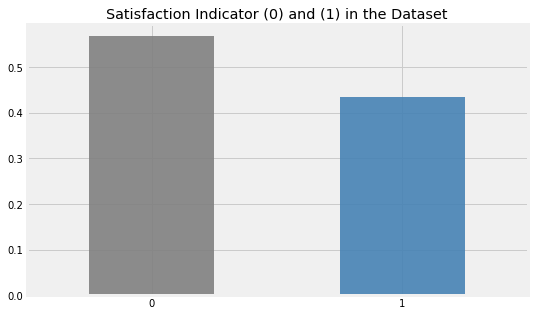

In [35]:
# Confirm satisfaction values changes
fig = plt.figure(figsize = (8,5))
traindf.satisfaction.value_counts(normalize = True).plot(kind='bar', color= ['gray','steelblue'], alpha = 0.9, rot=0)
plt.title('Satisfaction Indicator (0) and (1) in the Dataset')
plt.show()



The plot shows a distribution of around 55%:45% between neutral/dissatisfied passengers and satisfied passengers respectively. So the data is quite balanced and it does not require any special treatment/resampling.

In [13]:
# Missing data
total = traindf.isnull().sum().sort_values(ascending=False)
percent = (traindf.isnull().sum()/traindf.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

,Total,Percent
Arrival_Delay_in_Minutes,310,0.002984
satisfaction,0,0.000000
Food_and_drink,0,0.000000
Customer_Type,0,0.000000
Age,0,0.000000


In [14]:
# Imputing missing value with mean
traindf['Arrival_Delay_in_Minutes'] = traindf['Arrival_Delay_in_Minutes'].fillna(traindf['Arrival_Delay_in_Minutes'].mean())
testdf['Arrival_Delay_in_Minutes'] = testdf['Arrival_Delay_in_Minutes'].fillna(testdf['Arrival_Delay_in_Minutes'].mean())

In [15]:
# Check the list of categorical variables in dataset
traindf.select_dtypes(include=['object']).columns

Index(['Gender', 'Customer_Type', 'Type_of_Travel', 'Class'], dtype='object')

In [16]:
# Replace NaN with mode for categorical variables
traindf['Gender'] = traindf['Gender'].fillna(traindf['Gender'].mode()[0])
traindf['Customer_Type'] = traindf['Customer_Type'].fillna(traindf['Customer_Type'].mode()[0])
traindf['Type_of_Travel'] = traindf['Type_of_Travel'].fillna(traindf['Type_of_Travel'].mode()[0])
traindf['Class'] = traindf['Class'].fillna(traindf['Class'].mode()[0])

In [17]:
testdf['Gender'] = testdf['Gender'].fillna(testdf['Gender'].mode()[0])
testdf['Customer_Type'] = testdf['Customer_Type'].fillna(testdf['Customer_Type'].mode()[0])
testdf['Type_of_Travel'] = testdf['Type_of_Travel'].fillna(testdf['Type_of_Travel'].mode()[0])
testdf['Class'] = testdf['Class'].fillna(testdf['Class'].mode()[0])

### 3.Survey Results of survey customer satisfaction responses

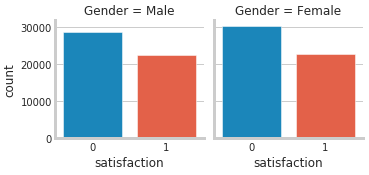

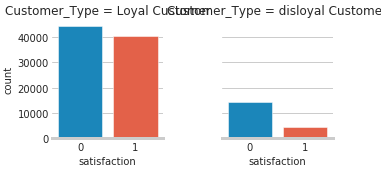

In [61]:
# seaborn graph satifaction info

with sns.axes_style(style='whitegrid'):
    g = sns.catplot("satisfaction", col="Gender", col_wrap=2, data=traindf, kind="count", height=2.5, aspect=1.0)  
    g = sns.catplot("satisfaction", col="Customer_Type", col_wrap=2, data=traindf, kind="count", height=2.5, aspect=1.0)
    g.set_xlabels(fontsize=10)
    g.set_ylabels(fontsize=10)
    
    g.despine(left=True)
  

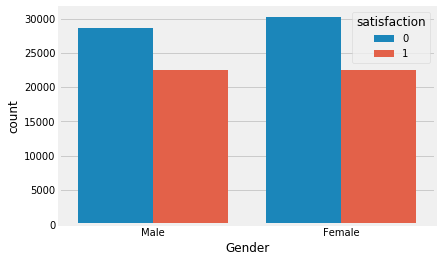

In [59]:
ax = sns.countplot(x="Gender", hue="satisfaction", data=traindf)

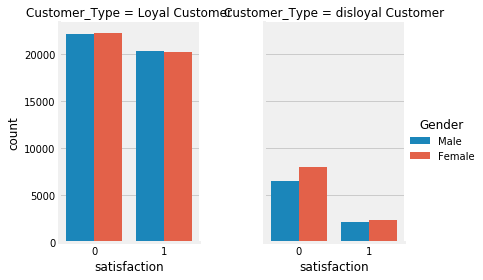

In [66]:
g = sns.catplot(x="satisfaction", hue="Gender", col="Customer_Type", data=traindf, kind="count",
                height=4, aspect=.7)

###### Gender Analysis Survey Results
The analysis hows gender-wise distribution of dissatisfied and satisfied customers are quite the same. 
For both male and female passengers, the number of dissatisfied customers is not higher than the satisfied customers.
###### Customer Type Analysis Survey Results
The number of loyal customers is higher than the non-loyal. 
Among loyal passengers, the ratio of satisfied and dissatidfied ones is 49:51.

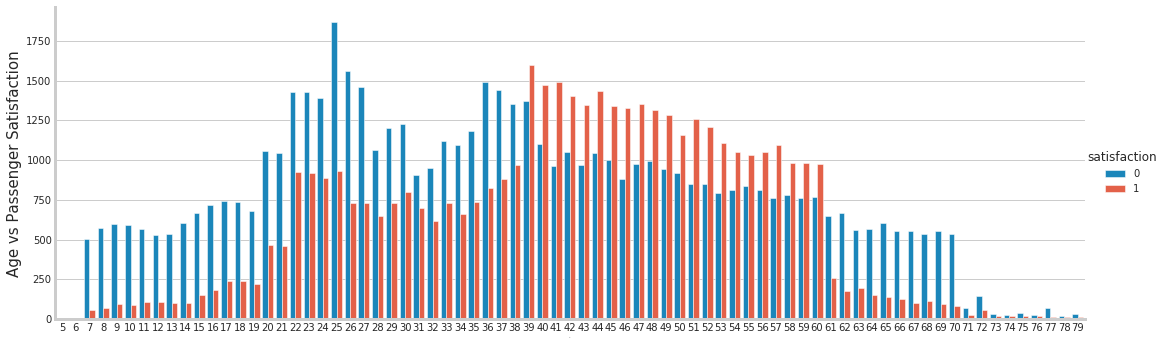

In [70]:
with sns.axes_style('whitegrid'):
    g = sns.catplot("Age", data=traindf, aspect=3.0, kind='count', hue='satisfaction', order=range(5, 80))
    g.set_ylabels('Age vs Passenger Satisfaction', fontsize=15)
    g.set_xlabels(fontsize=0.5)

###### Age Analysis Survey Results
From age 7-38 and from age 61-79 ranges, quotient of dissatisfied passengers is higher compared to satisfied passengers. 
In age 39-60 range, quotient of satisfied passengers is higher compared to dissatisfied passengers.

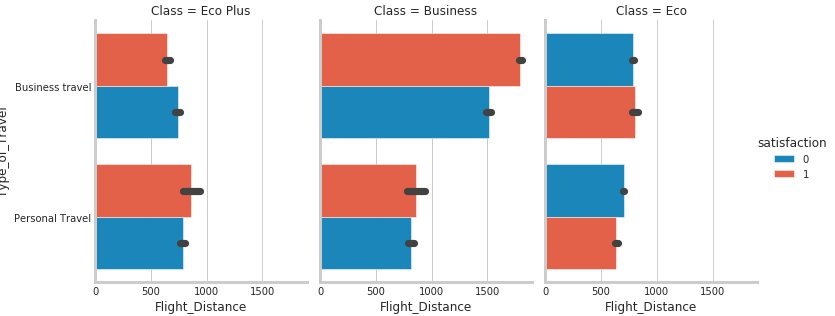

In [71]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Flight_Distance", y="Type_of_Travel", hue="satisfaction", col="Class", data=traindf, kind="bar", height=4.5, aspect=.8)
    g.set_xlabels(fontsize=12)
    g.set_ylabels(fontsize=12)

###### Type of Travel, Class, Flight Distance Survey Results: 
For business travel in business class category, the number of satisfied passengers are higher than longer flight distance. 
For other combinations, there is almost equal distribution of satisfied and dissatisfied passengers.

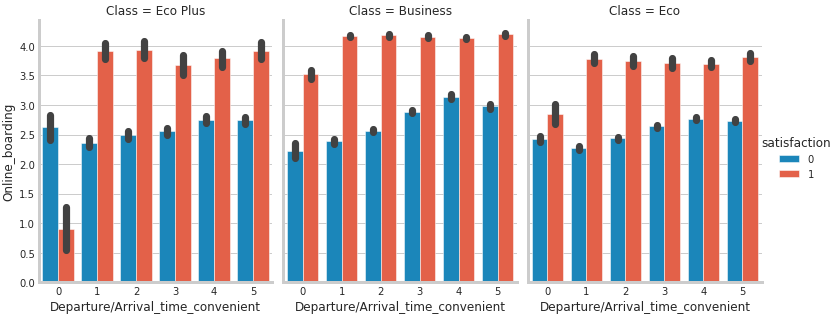

In [72]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Departure/Arrival_time_convenient", y="Online_boarding", hue="satisfaction", col="Class", data=traindf, kind="bar", height=4.5, aspect=.8)
    g.set_xlabels(fontsize=12)
    g.set_ylabels(fontsize=12)

######  Survey Results, online Boarding, departure/Arrival time Convenience grouped by Class: 
- For Eco Plus class, Departure/Arrival time has negative responses with high number of dissatisfied passengers, even when online boarding has high satisfaction. 
- For other combinations, there is higher level of satisfaction.

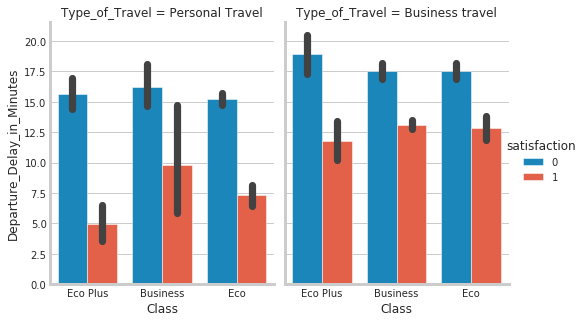

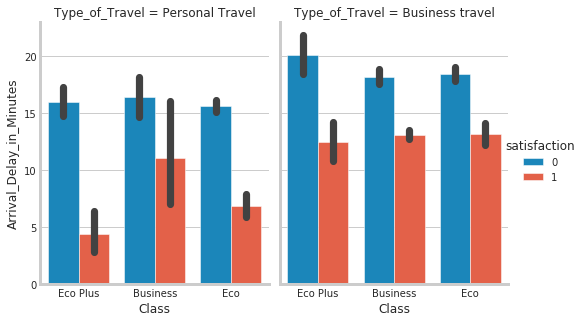

In [73]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Class", y="Departure_Delay_in_Minutes", hue="satisfaction", col="Type_of_Travel", data=traindf, kind="bar", height=4.5, aspect=.8)
    g = sns.catplot(x="Class", y="Arrival_Delay_in_Minutes", hue="satisfaction", col="Type_of_Travel", data=traindf, kind="bar", height=4.5, aspect=.8)
    g.set_xlabels(fontsize=12)
    g.set_ylabels(fontsize=12)

###### Survey Results, departure delay, arrival delay grouped by type of travel: 
- For personal travel (specially Eco Plus and Eco), there is higher number of dissatisfied passengers when arrival delay in minutes is high. 
- By minute comparison, all combinations have higher no. of dissatisfied passengers compared to no. of satisfied passengers.

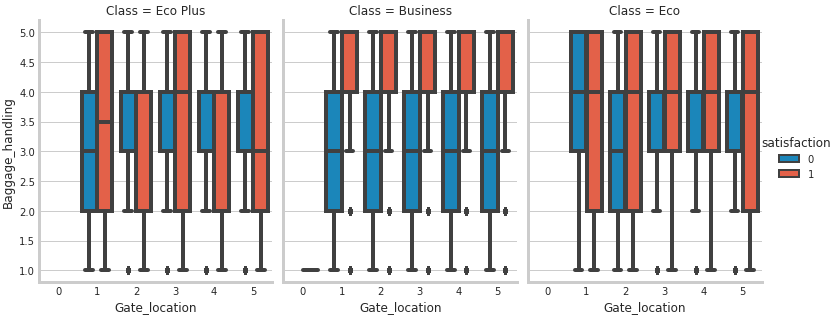

In [75]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Gate_location", y="Baggage_handling", hue="satisfaction", col="Class", data=traindf, kind="box", height=4.5, aspect=.8)

##### Survey Results, baggage handling, gate location grouped by class: 
- For business class, it is observed that all gate locations have higher number of dissatisfied passengers when baggage handling is not done perfectly well (rating <= 4). 
- For Eco Plus, when the gate location is 1 and for Eco, when the gate location is 2, even when the baggages are handled in a mediocre way (rating in range 2.0 - 4.0), passengers remained dissatisfied.

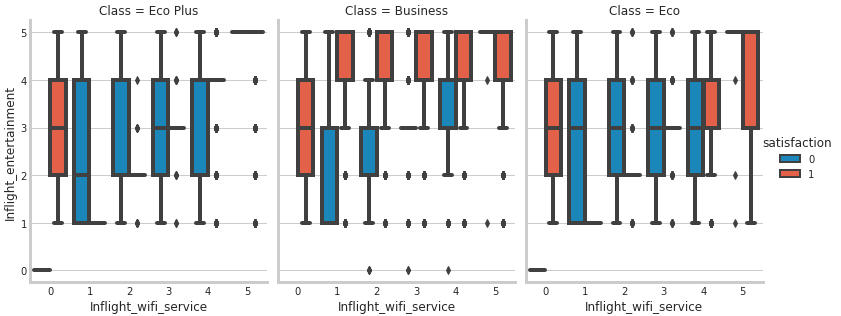

In [77]:
with sns.axes_style('whitegrid'):
    g = sns.catplot(x="Inflight_wifi_service", y="Inflight_entertainment", hue="satisfaction", col="Class", data=traindf, kind="box", height=4.5, aspect=.8)

##### Survey Results, inflight entertainment, inflight wi-fi service grouped by Class: 
- Eco Plus passengers are mostly satisfied without in-flight wi-fi service (rating 0) and medium level of in-flight entertainment (rating 2 - 4). 
- For Business class passengers, only highest level of in-flight entertainment (rating 5) can make them satisfied. 
- For Eco passengers, high level of in-flight entertainment (rating 3 - 5) and very high wi-fi service availability (rating 5) can make them satisfied.

In [ ]:
with sns.axes_style(style='ticks'):
    g = sns.catplot("satisfaction", col="Ease_of_Online_booking", col_wrap=6, data=trainpd, kind="count", height=2.5, aspect=.9)

In [ ]:
with sns.axes_style(style='ticks'):
    g = sns.catplot("satisfaction", col="Seat_comfort", col_wrap=6, data=trainpd, kind="count", height=2.5, aspect=.8)

In [ ]:
with sns.axes_style(style='ticks'):
    g = sns.catplot("satisfaction", col="Food_and_drink", col_wrap=6, data=trainpd, kind="count", height=2.5, aspect=.8)

In [ ]:
Ease of Online Booking, Seat Comfort, Cleanliness, Food and Drink: For all of these features, maximum no. of satisfied 
passengers belong  to the category of 4 and 5 rating givers. Below rating 4, passengers are mostly dissatisfied.

In [ ]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))

table1 = pd.crosstab(trainpd['satisfaction'], trainpd['Checkin_service'])
sns.heatmap(table1, cmap='Oranges', ax = axarr[0][0])
table2 = pd.crosstab(trainpd['satisfaction'], trainpd['Inflight_service'])
sns.heatmap(table2, cmap='Blues', ax = axarr[0][1])
table3 = pd.crosstab(trainpd['satisfaction'], trainpd['On-board_service'])
sns.heatmap(table3, cmap='pink', ax = axarr[1][0])
table4 = pd.crosstab(trainpd['satisfaction'], trainpd['Leg_room_service'])
sns.heatmap(table4, cmap='bone', ax = axarr[1][1])

In [ ]:
Checkin Service, Inflight Service, On-board Service, Leg-room Service: For checkin service, 0-2 rating givers are predominantly dissatisfied. For other three services, only 4 and 5 rating givers belong to satisfied passengers category.

In [ ]:
Label Encoding of Categorical Variables


In [ ]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in trainpd.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    trainpd[col] = lencoders[col].fit_transform(trainpd[col])
#print (trainpd.select_dtypes)

In [ ]:
lencoders_t = {}
for col in testpd.select_dtypes(include=['object']).columns:
    lencoders_t[col] = LabelEncoder()
    testpd[col] = lencoders_t[col].fit_transform(testpd[col])

In [ ]:
Outliers Detection and Removal

In [ ]:
Q1 = trainpd.quantile(0.25)
Q3 = trainpd.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
# Removing outliers from dataset
trainpd = trainpd[~((trainpd < (Q1 - 1.5 * IQR)) |(trainpd > (Q3 + 1.5 * IQR))).any(axis=1)]
trainpd.shape

In [ ]:
Correlation among Features

In [ ]:
corr = trainpd.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(150, 1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [ ]:
#"Ease_of_Online_booking" is highly correlated with "Inflight_wifi_service". Also "Inflight_service" is highly correlated
#with "Baggage_handling". But no pair is having corr. coefficient exactly equal to 1. 
#So there is no perfect multicollinearity. Hence we are not discarding any variable.

### Top 10 Feature Selection through Chi-Square

In [ ]:
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(trainpd)
#modified_data = pd.DataFrame(r_scaler.transform(trainpd), index=train['id'], columns=train.columns)
modified_data = pd.DataFrame(r_scaler.transform(train), columns=train.columns)
modified_data.head()

In [ ]:
#Define features and target (this is helpful in case you would like to drop any features that harm model performance)
features = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
target = ['satisfaction']

In [ ]:
# Split into test and train
X_train = trainpd[features]
y_train = trainpd[target].to_numpy()
X_test = testpd[features]
y_test = testpd[target].to_numpy()



In [ ]:
# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
# Drop unnecessary data
payroll_data1= payroll_data.drop(["First Name", "Last Name", "Mid Init"], axis="columns")

In [ ]:
payroll_data1.head(3)

In [ ]:
#The info() function is used to print a concise summary of a DataFrame. 
payroll_data1.count()

In [ ]:
payroll_data1.info()

In [ ]:
#Data cleaning (Transform from ELT)
#payroll_data1["Title Description"].value_counts()

In [ ]:
payroll_data1.nunique()

In [ ]:
#preparing data to clean convert to string
payroll_data1["Base Salary", "Regular Gross Paid", "Total OT Paid", "Total Other Pay"] = payroll_data1["Base Salary"].astype(str)

In [ ]:
# Minor Data Munging to Re-Format the Data Frames
payroll_data1["Base Salary"] = payroll_data1["Base Salary"].astype(str)
payroll_data1["Regular Gross Paid"] = payroll_data1["Regular Gross Paid"].astype(str).str.strip()
payroll_data1["Total OT Paid"] = payroll_data1["Total OT Paid"].astype(str)
payroll_data1["Total Other Pay"] = payroll_data1["Total Other Pay"].astype(str)

In [ ]:
# Convert data to Integer and floats.
payroll_data1["Base Salary", "Regular Gross Paid", "Total OT Paid", "Total Other Pay"] = payroll_data1["Base Salary"].str.replace('$','')
payroll_data1["Title Description"] = payroll_data1["Title Description"].astype(str).str.strip()
payroll_data1["Pay Basis"] =  payroll_data1["Pay Basis"].str.strip()


In [ ]:
#to clean-up non-alpha numberic characters
payroll_data1["Title Description"]= payroll_data1["Title Description"].str.replace('[^A-Za-z\s]+', '')

In [ ]:
#Convert columns back to float and integers
payroll_data1["Base Salary"] = payroll_data1["Base Salary"].astype(float)
payroll_data1["Base Salary"] = payroll_data1["Base Salary"].astype(int)
payroll_data1["Regular Gross Paid"] = payroll_data1["Regular Gross Paid"].astype(float)
payroll_data1["Total OT Paid"] = payroll_data1["Total OT Paid"].astype(float)
payroll_data1["Total Other Pay"] = payroll_data1["Total Other Pay"].astype(float)
payroll_data1.head()
math.floor(1.1111)
payroll_data1.describe()

# Analysis and Visualizatons 

In [ ]:
payroll_data1["Fiscal Year"].unique() 

In [ ]:
annual_pay = payroll_data1[(payroll_data1["Pay Basis"] == "per Annum")]

In [ ]:
# Subset of Data,to avoid negative values and zeros. 
x = annual_pay[(annual_pay["Regular Gross Paid"] > 10000) & (annual_pay["Base Salary"] > 10000)]

In [ ]:
# Visualization for lowest paid employees
x.groupby(["Fiscal Year","Title Description"])["Regular Gross Paid"].mean().sort_values(ascending=True)[:15].plot(kind='barh',color='lightslategray')
plt.xticks(fontsize=10, color="gray", weight="bold")
plt.yticks(fontsize=10, color="cadetblue",weight="bold")
plt.ylabel('')
plt.xlabel('$',fontsize=10)
plt.rcParams['figure.figsize']= 7,7
plt.text(x=-3000, y=15.5, s="15 Lowest Paid Employees", fontsize=25, weight="bold",color="cadetblue",alpha=.98)
plt.text(x=-3000, y=14.95, s="Employees with Average Annual Pay above $10,000 -  FY2014-2019",fontsize=8, weight="bold",color="blue",alpha=.45)
# Show the Figure

plt.show() 
plt.savefig('output/lowest_Paid_employees.png')

In [ ]:
# Visualization for highest paid employees
x.groupby(["Fiscal Year","Title Description"])["Regular Gross Paid"].mean().sort_values(ascending=False)[:15].plot(kind="barh",color="lightslategray")
# Label the axes
plt.xticks(fontsize=11, weight= "bold",rotation=0, color="gray")
plt.yticks(fontsize=9.0, weight="bold",color="cadetblue")
plt.ylabel('')
plt.xlabel('$',fontsize=9)
plt.rcParams['figure.figsize']= 7,7
plt.title("15 Highest Paid Employees", loc="left",fontsize=25, color="cadetblue", fontweight= "bold", alpha=.90)
plt.text(x=-5, y=-2.5, s="Employees on Annual Pay above $10,000",weight="bold", fontsize=10,color="gray", alpha=.45)
plt.axvline(x=(stats.trim_mean(x["Regular Gross Paid"].values, 0.1)), color="b", linewidth=2.3, alpha=.75)
plt.annotate("Trimmed Mean",fontsize=12, color="b", fontweight= "bold",xy=(90000,9), xytext=(65000,9), arrowprops=dict(arrowstyle='<-',facecolor="red",connectionstyle="arc3"))

# Show the Figure
plt.tight_layout()
plt.show() 
plt.savefig('output/highest_Paid_employees.png')

In [ ]:
#Graph Gross Pay by work location, top 15
x.groupby(["Work Location Borough", "Fiscal Year"])["Regular Gross Paid"].sum().sort_values(ascending=True)[:15].plot(kind='barh',color='lightslategray')
plt.xlabel('$',fontsize=10)
plt.ylabel(" ")
plt.rcParams['figure.figsize']= 9,7
plt.title(" 15 Highest Regular Gross Pay Employees by Borough", loc="left",fontsize=15, color="cadetblue", fontweight= "bold", alpha=.90)

plt.xticks(fontsize=11, weight= "bold",rotation=0, color="gray")
plt.yticks(fontsize=9.0, weight="bold",color="cadetblue")
plt.text(x=-5, y=-2.5, s="Employees on Annual Pay above $10,000",weight="bold", fontsize=10,color="gray", alpha=.45)

# Show the Figure
plt.tight_layout()
plt.show()
#save figure
plt.savefig('output/Work_Location_Borough.png')

In [ ]:
## 2019 Agencies with most employes
x1 = payroll_data1[payroll_data1["Fiscal Year"] == 2019]["Agency Name"].value_counts().sort_values(ascending=False)[0:20].values
y1 = payroll_data1[payroll_data1["Fiscal Year"] == 2019]["Agency Name"].value_counts().sort_values(ascending=False)[0:20].index
plt.rcParams["figure.figsize"]= 9,7
ax1 = sb.barplot(x=x1, y=y1, palette="vlag", saturation=1)
ax1.figure.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
sb.set_context("poster", font_scale=2)

plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')

#Remove the top and right spines from plot(s). Figure to despine all axes of, defaults to the current figure.
sb.despine()
ax1.set_title("2019 Top 20 Agencies With Most Employees",loc="left",fontsize=15, color="cadetblue", fontweight= "bold", alpha=.90)

plt.xlabel('# of Employees',fontsize=5)

# Show the Figure
plt.tight_layout()
plt.show()
#save figure
plt.savefig('output/2019_Agencies_w_most employes.png')

In [ ]:
possibilities = [u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']

# For values greater than 20K, calculated mean and median for regular gross pay
x = payroll_data1[(payroll_data1["Pay Basis"] == "per Annum") & (payroll_data1["Regular Gross Paid"] > 20000) & (payroll_data1["Base Salary"] > 20000)]

# Regular Gross Pay Plot
x.groupby(x["Fiscal Year"])["Regular Gross Paid"].median().plot(linewidth=4,linestyle="dashed", c='green', markersize=5)
x.groupby(x["Fiscal Year"])["Regular Gross Paid"].mean().plot(linewidth=4, linestyle="dashed", c='blue', markersize=5)
plt.rcParams["figure.figsize"]= 10,7
plt.xlim(left=2014, right=2019)

#add title and descriptions
plt.title("Regular Gross Pay", loc="left",fontsize=25, color="cadetblue", fontweight= "bold", alpha=.90)


plt.text(x=2014, y=75850, s="Employees On Annual Pay above $20,000",fontsize=12,alpha=.75)

plt.text(x=2017, y=65400, s="Median", color='green', weight='bold', rotation=7, fontsize=14)
plt.text(x=2016, y=69000, s="Mean", color='blue', weight='bold', rotation=7, fontsize=14)
plt.xticks(range(2014,2019,1), fontsize=14, weight= 'bold')
plt.yticks(fontsize=14, weight= 'bold')
plt.ylabel("Regular Gross Paid", fontsize=14, weight= 'bold')
plt.xlabel("Fiscal Year", fontsize=14, weight= 'bold')
plt.grid("True")
plt.legend(["Median", "Mean"],loc="right", fontsize=14, fancybox=True)

plt.grid(color='b', ls = '-.', lw = 0.25)

# Show the Figure
plt.tight_layout()
plt.show()
# Save the Figure
plt.savefig('output/Regular_Gross_Pay_Plot.png')

In [ ]:
# Top 10 Boroughs with Highest Average Gross Pay FY2019

fy19 = x[x["Fiscal Year"]==2019]
fy19.groupby(["Work Location Borough"])["Regular Gross Paid"].mean().sort_values(ascending=False)[:10].plot(kind='bar',color='darkcyan')

plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.rcParams["figure.figsize"]= 10,10

plt.title("Top 10 Boroughs with Highest Average Gross Pay in 2019", loc="left",fontsize=25, color="cadetblue", fontweight= "bold", alpha=.90)

plt.text(x=-.8, y=-15000, s="Employees On Annual Pay above $20,000",fontsize=12,alpha=.75)
plt.xlabel('')
plt.axhline(y=fy19["Regular Gross Paid"].mean(), color='b', linewidth=1.3,linestyle='dashdot', alpha=.75)
plt.text(x = 2.5, y = (fy19["Regular Gross Paid"].mean() + 240), s="Average Gross Pay", fontsize=18, color="black",weight='bold')

# Show the Figure

plt.show()
# Save the Figure
plt.savefig('output/Highest_Average_Gross_2019Plot.png')

In [ ]:
# Top 10 Boroughs with Highest Average Gross Pay FY2018
plt.style.use('ggplot')
fy18 = x[x["Fiscal Year"]==2018]
fy18.groupby(["Work Location Borough"])["Regular Gross Paid"].mean().sort_values(ascending=False)[:10].plot(kind='bar',color='darkcyan')
plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.rcParams["figure.figsize"]= 10,10

plt.title("Top 10 Boroughs with Highest Average Gross Pay in 2018", loc="left",fontsize=25, color="cadetblue", fontweight= "bold", alpha=.90)
plt.text(x=-.8, y=-15000, s="Employees On Annual Pay above $20,000",fontsize=12,alpha=.75)
plt.xlabel('')
plt.axhline(y=fy18["Regular Gross Paid"].mean(), color='w', linewidth=1.3,linestyle='dashdot', alpha=.75)
plt.text(x = 2.5, y = (fy18["Regular Gross Paid"].mean() + 240), s="Average Gross Pay", fontsize=18, color="black",weight='bold')

# Show the Figure
plt.show()
# Save the Figure
plt.savefig('output/Highest_Average_Gross_2018Plot.png')

In [ ]:
# Top 10 Boroughs with Highest Average Gross Pay FY2017
plt.style.use('ggplot')
fy17 = x[x["Fiscal Year"]==2017]
fy17.groupby(["Work Location Borough"])["Regular Gross Paid"].mean().sort_values(ascending=False)[:10].plot(kind='bar',color='darkcyan')
plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.rcParams["figure.figsize"]= 10,10

plt.title("Top 10 Boroughs with Highest Average Gross Pay in 2017", loc="left",fontsize=25, color="cadetblue", fontweight= "bold", alpha=.90)

plt.text(x=-.8, y=-15000, s="Employees On Annual Pay above $20,000",fontsize=12,alpha=.75)
plt.xlabel('')
plt.axhline(y=fy17["Regular Gross Paid"].mean(), color='b', linewidth=1.3,linestyle='dashdot', alpha=.75)
plt.text(x = 2.5, y = (fy17["Regular Gross Paid"].mean() + 240), s="Average Gross Pay", fontsize=18, color="black",weight='bold')

# Show the Figure
plt.show()
# Save the Figure
plt.savefig('output/Highest_Average_Gross_2017Plot.png')


In [ ]:
# Top 10 Boroughs with Highest Average Gross Pay FY2016
fy16 = x[x["Fiscal Year"]==2016]
fy16.groupby(["Work Location Borough"])["Regular Gross Paid"].mean().sort_values(ascending=False)[:10].plot(kind='bar',color='darkcyan')

plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.rcParams["figure.figsize"]= 10,10

plt.title("Top 10 Boroughs with Highest Average Gross Pay in 2016", loc="left",fontsize=25, color="cadetblue", fontweight= "bold", alpha=.90)

plt.text(x=-.8, y=-15000, s="Employees On Annual Pay above $20,000",fontsize=12,alpha=.75)
plt.xlabel('')
plt.axhline(y=fy16["Regular Gross Paid"].mean(), color='b', linewidth=1.3,linestyle='dashdot', alpha=.75)
plt.text(x = 2.5, y = (fy16["Regular Gross Paid"].mean() + 240), s="Average Gross Pay", fontsize=18, color="black",weight='bold')

# Show the Figure
plt.show()
# Save the Figure
plt.savefig('output/Highest_Average_Gross_2016Plot.png')

In [ ]:
import seaborn as sns
sns.set_style("white")

#Historgram Distribution for gross pay

from scipy.stats import norm

payroll_data2 = payroll_data1[(payroll_data1["Pay Basis"] == "per Annum") & (payroll_data1["Regular Gross Paid"] > 10000) & (payroll_data1["Base Salary"] > 10000)]
f14 = payroll_data2[payroll_data2["Fiscal Year"]==2014]
f15 = payroll_data2[payroll_data2["Fiscal Year"]==2015]
f16 = payroll_data2[payroll_data2["Fiscal Year"]==2016]
f17 = payroll_data2[payroll_data2["Fiscal Year"]==2017]
f18 = payroll_data2[payroll_data2["Fiscal Year"]==2018]
f19 = payroll_data2[payroll_data2["Fiscal Year"]==2019]

# Year 2016 Distribution
sb.set_context("paper")
sb.distplot(f19["Regular Gross Paid"],fit=norm,kde=False)

plt.xlim(left=0, right=200000)

#Title and Description
plt.suptitle("Distribution of Gross Salary Fiscal Year 2016 ",fontweight='bold', fontsize=24, color="cadetblue", alpha=.90)
plt.title("Sub-set of employees with salary above $10K", loc="left",fontsize=20, color="cadetblue", fontweight= "bold", alpha=.90)


plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.grid(color='b', ls = '-.', lw = 0.25)
# Show the Figure
plt.show()
# Save the Figure
plt.savefig('output/Dist_Gross_Pay_FY16Plot.png')

In [ ]:
# Year 2017 Distribution    
sb.set_context("paper")
sb.distplot(f17["Base Salary"],fit=norm,kde=False)
sns.set_style("white")

#Title and Description
plt.xlim(left=0, right=200000)
plt.title("Distribution of Base Pay 2017", loc="left",fontsize=25, color="cadetblue", fontweight= "bold", alpha=.90)
plt.text(x=100000, y=.000013, s="Sub-set of employees with salary above $10K", fontsize=8,alpha=.65)
# Show the Figure
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.show()
#save figure
plt.savefig('output/Dist_base_Salary_FY17Plot.png')

In [ ]:
# Year 2018 Distribution    
sb.set_context("paper")
sb.distplot(f18["Base Salary"],fit=norm,kde=False)
sns.set_style("white")

#Title and Description
plt.xlim(left=0, right=200000)
plt.title("Distribution of Base Salary 2018", loc="left",fontsize=25, color="cadetblue", fontweight= "bold", alpha=.90)
plt.text(x=100000, y=.000013, s="Sub-set of employees with salary above $10K", fontsize=8,alpha=.65)

plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.grid(color='b', ls = '-.', lw = 0.25)
# Show the Figure
plt.show()
#save figure
plt.savefig('output/Dist_base_salary_FY18Plot.png')

In [ ]:
# Subset Data for Year 2019 Distribution    
sb.set_context("paper")
sb.distplot(f17["Base Salary"],fit=norm,kde=False)


#Title and Description
possibilities = [u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']
plt.xlim(left=0, right=200000)
plt.suptitle("Distribution of Base Salary Fiscal Years 2019 vs. 2018",fontweight='bold', fontsize=24, color="cadetblue", alpha=.90)

plt.text(x=100000, y=.000013, s="Sub-set of employees with salary above $10K", fontsize=8,alpha=.65)

plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')

#Comparison to prior FY distribution
sb.set_context("paper")
sb.distplot(f18["Regular Gross Paid"],fit=norm,kde=False, color="b")
plt.grid(color='b', ls = '-.', lw = 0.25)
# Show the Figure
plt.show()
#save figure
plt.savefig('output/Dist_Gross_Pay_FY19Plot.png')

In [ ]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
possibilities = [u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']

# Distribution of Base Salary for Annual Employees making over 10,000
fig1 = plt.figure(figsize=(12,9))
ax2 = fig1.add_subplot(221)
ax3 = fig1.add_subplot(222)
ax4  = fig1.add_subplot(223)
ax5 = fig1.add_subplot(224)
 # titles 
fig1.suptitle("Base Salary Distribution (Salary > $10,000)",fontweight='bold', fontsize=22)
ax2.title.set_text('Fiscal Year 2016')
ax3.title.set_text('Fiscal Year 2017')
ax4.title.set_text('Fiscal Year 2018')
ax5.title.set_text('Fiscal Year 2019')
#add grids
ax2.grid(color='b', ls = '-.', lw = 0.25)
ax3.grid(color='b', ls = '-.', lw = 0.25)
ax4.grid(color='b', ls = '-.', lw = 0.25)
ax5.grid(color='b', ls = '-.', lw = 0.25)

#subplot graph data
sb.distplot(f16["Base Salary"],kde=False, ax=ax2)
sb.distplot(f17["Base Salary"],kde=False, ax=ax3)
sb.distplot(f18["Base Salary"],kde=False, ax=ax4)
sb.distplot(f19["Base Salary"],kde=False, ax=ax5)
plt.subplots_adjust(left=.05, right=.95,hspace=.5, wspace=.35,top=.85)
plt.xlim(left=0, right=200000)
plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')

# Show the Figure
plt.show()
#save figure
plt.savefig('output/Dist_BaseSal.png')

In [ ]:
# Distribution of Base Salary for Annual Employees making over 10,000
possibilities = [u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']

fig1 = plt.figure(figsize=(12,9))
ax2 = fig1.add_subplot(221)
ax3 = fig1.add_subplot(222)
ax4  = fig1.add_subplot(223)
ax5 = fig1.add_subplot(224)
 # titles 
fig1.suptitle("Base Salary Distribution (Salary > $10,000)",fontweight='bold', fontsize=22)
ax2.title.set_text('Fiscal Year 2016')
ax3.title.set_text('Fiscal Year2017')
ax4.title.set_text('Fiscal Year2018')
ax5.title.set_text('Fiscal Year2019')
sb.distplot(f16["Base Salary"],fit=norm,kde=False, ax=ax2)
ax2.set_xlim(0,185000)
ax3.set_xlim(0,185000)
ax4.set_xlim(0,185000)
ax5.set_xlim(0,185000)


sb.distplot(f17["Base Salary"],fit=norm,kde=False, ax=ax3)
plt.xlim(left=0, right=200000)
sb.distplot(f18["Base Salary"],fit=norm,kde=False, ax=ax4)
plt.xlim(left=0, right=200000)
sb.distplot(f19["Base Salary"], ax=ax5)
plt.subplots_adjust(left=.05, right=.95,hspace=.5, wspace=.35,top=.85)
plt.xlim(left=0, right=175000)

plt.xticks(fontsize=8, weight= 'bold',rotation=0, color='black')
plt.yticks(fontsize=8, weight= 'bold',rotation=0, color='black')

# Show the Figure
plt.show()
#save figure
plt.savefig('output/Dist_BaseSalDistribution.png')

In [ ]:
payroll_data2.describe()

In [ ]:
# distribution of Gross Pay in 2019.

possibilities = [u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']

plt.style.use('seaborn-darkgrid')
plt.suptitle("Distribution of of Gross Pay in FY 2019 ",fontweight='bold', fontsize=24, color="cadetblue", alpha=.90)

sb.kdeplot(payroll_data2["Regular Gross Paid"], shade=True, color="blue",clip=(0,240000))


# Show the Figure
plt.show()
#save figure
plt.savefig('output/Dist_GrossPay.png')
